# Нейрон с различными функциями активации

В этом задании нужно будет: 
- самостоятельно реализовать класс **`Neuron()`** с различными функциями активации (ReLU, LeakyReLU и ELU)

- обучить и протестировать этот класс на сгенерированных и реальных данных

**Достаточно реализовать ReLU и ещё одну из двух.**

In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

In [2]:
np.random.seed(42)

В данном случае мы снова решаем задачу бинарной классификации (2 класса: 1 или 0). Мы уже выяснили (в ноутбуке про `logloss`), что плохо брать для классификации квадратичную функцию потерь, однако здесь для простоты возьмём её:

$$
Loss(\hat{y}, y) = \frac{1}{n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2
$$  

Здесь $w \cdot X_i$ - скалярное произведение, а $\hat{y_i} = \sigma(w \cdot X_i) =\frac{1}{1+e^{-w \cdot X_i}} $ - сигмоида ($i$ -- номер объекта в выборке). 

In [3]:
def loss(y_pred, y):
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    return 0.5 * np.mean((y_pred - y) ** 2)

Далее будут предложены несколько функций активации, и Вам нужно реализовать класс `Neuron` по аналогии с тем, как это было на семинаре. Сам принцип тот же, но меняются формула обновления весов и формула предсказания.

<h2 style="text-align: center;"><b>Нейрон с ReLU (Recitified Linear Unit)</b></h2>  

ReLU самая часто используемая (по крайней мере, пару лет назад) функция активации в нейронных сетях. Выглядит она очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В (свободном) переводе Rectified Linear Unit = "Усечённая линейная функция". Собственно, мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) = 
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

(помните, что $w \cdot X_i$ -- это число в данном случае (результат скалярного произведения двух векторов)).

Тогда формула для обновления весов при градиентном спуске будет такая (в матричном виде, рекмоендуем вывести самим то, как это получается из формулы для одного объекта):

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

(напоминаем, что здесь $w \cdot X$ -- матричное произведение вектора $w$ (ведь вектор -- тоже матрица, не так ли?) и матрицы $X$ )

Почему в первом случае будет 0? Потому что в формулу $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [4]:
def relu(x):
    """ReLU-функция"""
    return np.maximum(0, x)

In [5]:
def relu_derivative(x):
    """Производная ReLU"""
    return np.where(x > 0, 1, 0)

Теперь нужно написать нейрон с ReLU. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [6]:
class NeuronReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b

    def activate(self, x):
        return relu(x)

    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        return self.activate(np.dot(X, self.w) + self.b)

    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = X.shape[0]
        grad_w = np.dot(X.T, (y_pred - y) * relu_derivative(np.dot(X, self.w) + self.b)) / n
        grad_b = np.sum((y_pred - y) * relu_derivative(np.dot(X, self.w) + self.b)) / n
        self.w -= learning_rate * grad_w
        self.b -= learning_rate * grad_b

    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """

        if self.w is None:
            self.w = np.zeros((X.shape[1], 1))

        loss_values = []  # значения функции потерь на различных итерациях обновления весов

        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            loss_values.append(loss(y, y_pred))
            self.backward_pass(X, y, y_pred)

        return loss_values

<h3 style="text-align: center;"><b>Тестирование нейрона с ReLU</b></h3>  

Здесь вам нужно самим протестировать новый нейрон **на тех же данных** ("Яблоки и Груши" и "Голос") по аналогии с тем, как это было проделано с перцептроном.
В итоге нужно вывести: 
* график, на котором будет показано, как изменяется функция потерь $Loss$ в зависимости от числа итераций обучения
* график с раскраской выборки нейроном

***ПРИМЕЧАНИЕ***: пожалуйста, почаще проверяйте `.shape` у матриц и векторов: `self.w`, `X` и `y` внутри класса. Очень часто ошибка решается транспонированием или `.reshape()`'ом. Не забывайте проверять, что на что Вы умножаете и какой вектор (какой размер) хотите получить на выходе -- это очень помогает не запутаться.

In [7]:
!gdown 1hpO1lqvbdZ6K5zO66erNcYMr2rv_EFF1 -O "./data/apples_pears.csv"
!gdown 1_1YvZgUAgjKuRKPkkVnJlzQJy7rgkqBR -O "./data/voice.csv"

Downloading...
From: https://drive.google.com/uc?id=1hpO1lqvbdZ6K5zO66erNcYMr2rv_EFF1
To: /Users/artyomfadeyev/GitHub/ITMO-PROBLEMS/Machine-Learning/V semester/data/apples_pears.csv
100%|███████████████████████████████████████| 43.6k/43.6k [00:00<00:00, 687kB/s]
Downloading...
From: https://drive.google.com/uc?id=1_1YvZgUAgjKuRKPkkVnJlzQJy7rgkqBR
To: /Users/artyomfadeyev/GitHub/ITMO-PROBLEMS/Machine-Learning/V semester/data/voice.csv
100%|██████████████████████████████████████| 1.07M/1.07M [00:00<00:00, 3.21MB/s]


In [8]:
apple_pears = pd.read_csv("./data/apples_pears.csv")
apple_pears.head()

,yellowness,symmetry,target
0,0.779427,0.257305,1.0
1,0.777005,0.015915,1.0
2,0.977092,0.304210,1.0
3,0.043032,0.140899,0.0
4,0.760433,0.193123,1.0


In [9]:
from sklearn.model_selection import train_test_split

X, y = apple_pears[['yellowness', 'symmetry']].values, apple_pears['target'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
neuron = NeuronReLU()
loss_values = neuron.fit(X_train, y_train)

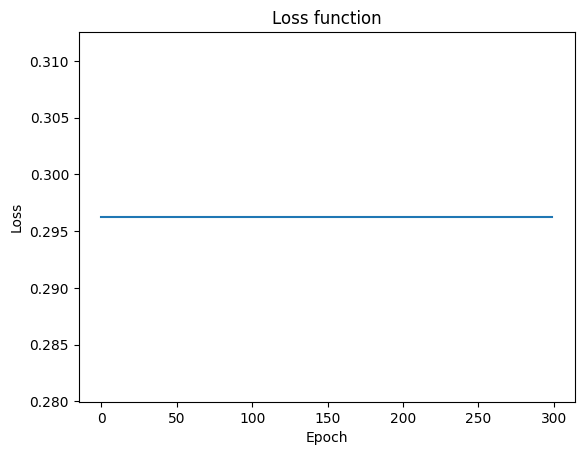

In [11]:
plt.plot(loss_values)
plt.title("Loss function")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Скорее всего сейчас у вас лосс -- это прямая линия, и вы видите, что веса не обновляются. Но почему?

Всё просто -- если присмотреться, то видно, что self.w и self.b иницилизируются нулями в начале `.fit()`-метода. Если расписать, как будет идти обновление, то видно, что из-за ReLU веса просто-напросто не будут обновляться, если начать с инициализации нулями. 

Это -- одна из причин, по которой в нейронных сетях веса инициализируют случаными числами (обычно из отрезка [0, 1)).

Обучите нейрон, инициализировав случайно веса (поставьте 10000 итераций). 

Закомментируйте инициализацию нулями в функции `.fit()` класса `NeuronReLU`

In [12]:
neuron = NeuronReLU(w=np.random.randn(X_train.shape[1], 1), b=np.random.randn(1))
loss_values = neuron.fit(X_train, y_train, num_epochs=10000)

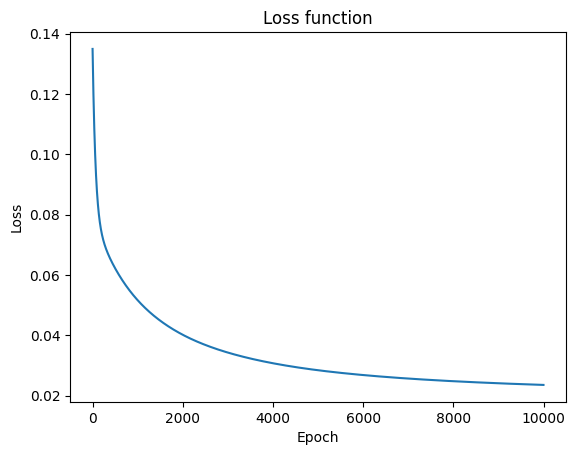

In [13]:
plt.plot(loss_values)
plt.title("Loss function")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Посмотрим, как предсказывает этот нейрон:

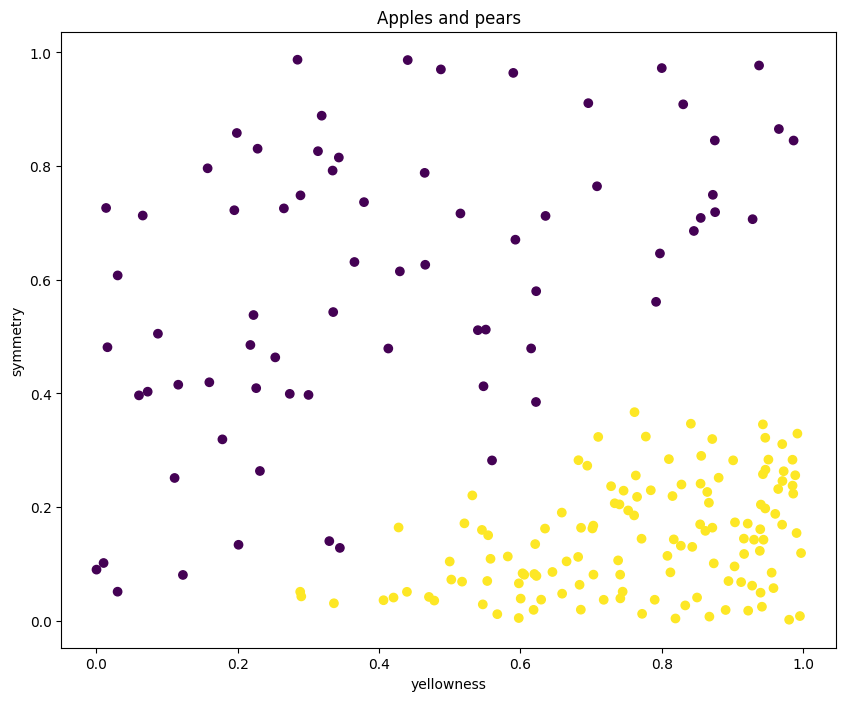

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.90        86
         1.0       0.88      1.00      0.94       114

    accuracy                           0.93       200
   macro avg       0.94      0.91      0.92       200
weighted avg       0.93      0.93      0.92       200



In [14]:
from sklearn.metrics import classification_report

plt.figure(figsize=(10, 8))
y_pred = np.array(neuron.forward_pass(X_test) > 0.5).ravel()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.title('Apples and pears')
plt.xlabel('yellowness')
plt.ylabel('symmetry')
plt.show()
print(classification_report(y_test, y_pred))

Есть одна тенденция: пороговая функция активации и сигмоида (обычно всё же только сигмоида) чаще используются именно на **выходном слое** нейросети в задаче классификации -- ими предсказывают вероятности объектов принадлежать одному из классов, в то время как продвинутые функции активации (ReLU и те, что будут дальше) используются внутри нейросети, то есть в **скрытых слоях**.

Нужно понимать, что ReLU не может вернуть отрицательные числа.

**Плюсы ReLU:**

* дифференцируемая (с доопределе
нием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде

**Возможные минусы ReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* зануляет все отрицательные входы, тем самым веса у занулённых нейронов могут часто *не обновляться*, эту проблему иногда называют *мёртвые нейроны*

С последней проблемой можно побороться, а именно:

<h2 style="text-align: center;"><b>Нейрон с LeakyReLU (Leaky Recitified Linear Unit)</b></h2>  

LeakyReLU очень слабо отличается от ReLU, но часто помогает сети обучаться быстрее, поскольку нет проблемы "мёртвых нейронов":

\begin{equation*}
LeakyReLU(x) =
 \begin{cases}
   \alpha x, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
LeakyReLU'(x) = 
 \begin{cases}
   \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

График этой функции:

<img src="https://cdn-images-1.medium.com/max/1600/0*UtLlZJ80TMIM7kXk." width=400 height=300>

Подставим LeakyReLu в Loss:

$$
Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (LeakyReLU(w \cdot X_i) - y_i)^2 =
\begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha \cdot w \cdot X_i - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}
$$  

Формула для обновления весов при градиентном спуске:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   \alpha X_i^T (w \cdot X_i - y), &{w \cdot X_i \le 0}\\
    X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте LeakyReLU и её производную:

In [15]:
def leaky_relu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.where(x > 0, x, alpha * x)

In [16]:
def leaky_relu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return np.where(x > 0, 1, alpha)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [17]:
class NeuronLeakyReLU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b

    def activate(self, x):
        """Активация нейрона"""
        return leaky_relu(x)

    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        return self.activate(np.dot(X, self.w) + self.b)

    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = X.shape[0]
        grad_w = np.dot(X.T, (y_pred - y) * leaky_relu_derivative(np.dot(X, self.w) + self.b))
        grad_b = np.sum((y_pred - y) * leaky_relu_derivative(np.dot(X, self.w) + self.b))
        self.w -= learning_rate * grad_w / n
        self.b -= learning_rate * grad_b / n

    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """

        if self.w is None:
            self.w = np.random.randn(X.shape[1], 1)

        loss_values = []  # значения функции потерь на различных итерациях обновления весов

        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            loss_values.append(loss(y, y_pred))
            self.backward_pass(X, y, y_pred)

        return loss_values

**Плюсы LeakyReLU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU

**Возможные минусы LeakyReLU:**

* не центрирована около 0 (может мешать скорости сходимсти)
* немного не устойчива к "шуму" (см. лекции Стэнфорда)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

neuron = NeuronLeakyReLU(w=np.random.randn(X_train.shape[1], 1), b=np.random.randn(1))
losses = neuron.fit(X_train, y_train, num_epochs=10000)

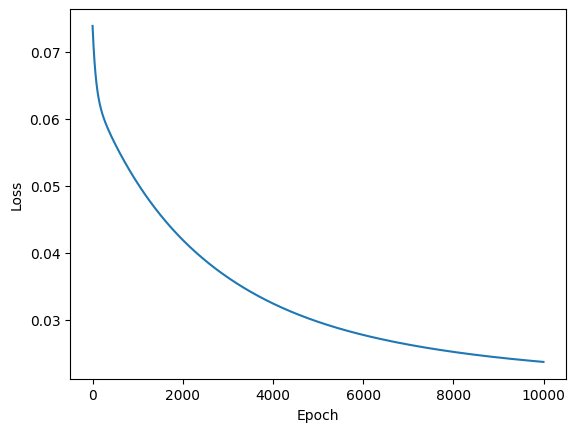

In [19]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

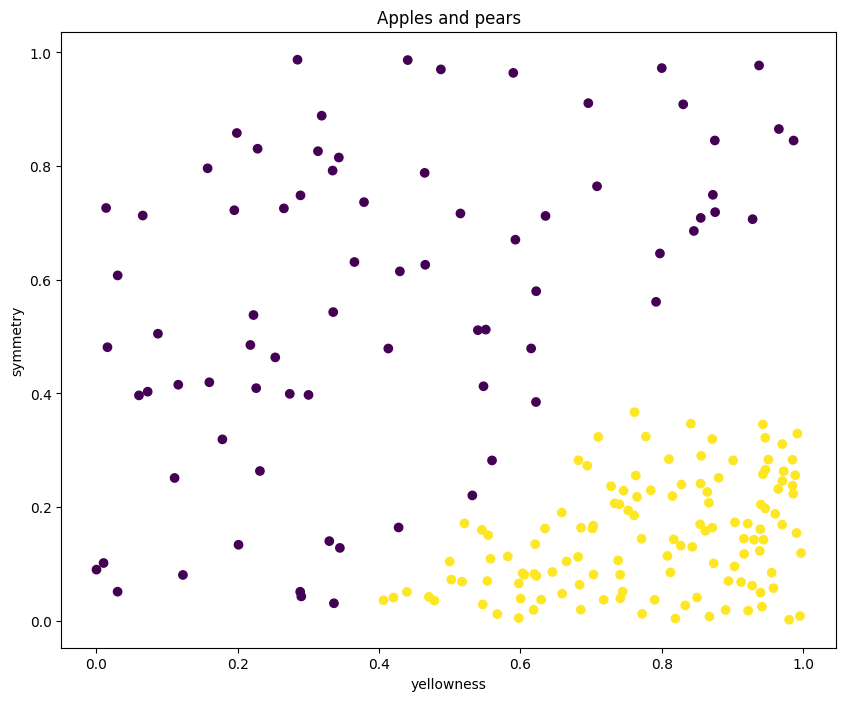

              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94        86
         1.0       0.92      1.00      0.96       114

    accuracy                           0.95       200
   macro avg       0.96      0.94      0.95       200
weighted avg       0.95      0.95      0.95       200



In [20]:
plt.figure(figsize=(10, 8))
y_pred = np.array(neuron.forward_pass(X_test) > 0.5).ravel()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.title('Apples and pears')
plt.xlabel('yellowness')
plt.ylabel('symmetry')
plt.show()
print(classification_report(y_test, y_pred))

<h2 style="text-align: center;"><b>Нейрон с ELU (Exponential Linear Unit)</a></b></h2>  

ELU -- не так давно предложенная (в 2015 году) функция активации, которая, как говорят авторы статьи, лучше LeakyReLU. Вот формула ELU:

\begin{equation*}
ELU(\alpha, x) =
 \begin{cases}
   \alpha (e^x - 1), &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

где $\alpha$ -- маленькое число от 0 до 1.

Производная здесь берётся так же, но вместо нуля будет $\alpha$:

\begin{equation*}
ELU'(x) = 
 \begin{cases}
   ELU(\alpha, x) + \alpha, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Здесь в производной использован постой трюк -- сделано $- \alpha + \alpha$, чтобы вычислять было проще.

График этой функции:

<img src="http://p0.ifengimg.com/pmop/2017/0907/A004001DD141881BFD8AD62E5D31028C3BE3FAD1_size14_w446_h354.png" width=500 height=400>

Подставим LeakyReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ELU(\alpha, w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n} 
 \begin{cases}
   (\alpha (e^{w \cdot X_i} - 1) - y_i)^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Здесь вам нужно выписать самим град спуск для весов. Брать производную "в лоб" некрасиво и неудобно. Нужно воспользоваться **правилом цепочки**, оно же **правило взятия производной сложной функции**:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n} 
 \begin{cases}
   , &{w \cdot X_i \le 0}\\
   , &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

* Реализуйте ELU и её производную:

In [21]:
def eelu(x, alpha=0.01):
    """LeakyReLU-функция"""
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

In [22]:
def elu_derivative(x, alpha=0.01):
    """Производная LeakyReLU"""
    return np.where(x > 0, 1, eelu(x, alpha) + alpha)

Теперь нужно написать нейрон с LeakyReLU функцией активации. Здесь всё очень похоже на перцептрон, но будут по-другому обновляться веса и другая функция активации:

In [23]:
class NeuronELU:
    def __init__(self, w=None, b=0):
        """
        :param: w -- вектор весов
        :param: b -- смещение
        """
        self.w = w
        self.b = b

    def activate(self, x):
        return eelu(x)

    def forward_pass(self, X):
        """
        Рассчитывает ответ нейрона при предъявлении набора объектов
        :param: X -- матрица примеров размера (n, m), каждая строка - отдельный объект
        :return: вектор размера (n, 1) из нулей и единиц с ответами нейрона 
        """
        return self.activate(np.dot(X, self.w) + self.b)

    def backward_pass(self, X, y, y_pred, learning_rate=0.005):
        """
        Обновляет значения весов нейрона в соответствии с этим объектом
        :param: X -- матрица входов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                learning_rate - "скорость обучения" (символ alpha в формулах выше)
        В этом методе ничего возвращать не нужно, только правильно поменять веса
        с помощью градиентного спуска.
        """
        n = X.shape[0]
        grad_w = np.dot(X.T, (y_pred - y) * elu_derivative(np.dot(X, self.w) + self.b))
        grad_b = np.sum((y_pred - y) * elu_derivative(np.dot(X, self.w) + self.b))
        self.w -= learning_rate * grad_w / n
        self.b -= learning_rate * grad_b / n

    def fit(self, X, y, num_epochs=300):
        """
        Спускаемся в минимум
        :param: X -- матрица объектов размера (n, m)
                y -- вектор правильных ответов размера (n, 1)
                num_epochs -- количество итераций обучения
        :return: losses -- вектор значений функции потерь
        """

        if self.w is None:
            self.w = np.random.randn(X.shape[1])

        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        for i in range(num_epochs):
            y_pred = self.forward_pass(X)
            loss_values.append(loss(y, y_pred))
            self.backward_pass(X, y, y_pred)

        return loss_values

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
neuron = NeuronLeakyReLU(w=np.random.randn(X_train.shape[1], 1), b=np.random.randn(1))
losses = neuron.fit(X_train, y_train, num_epochs=10000)

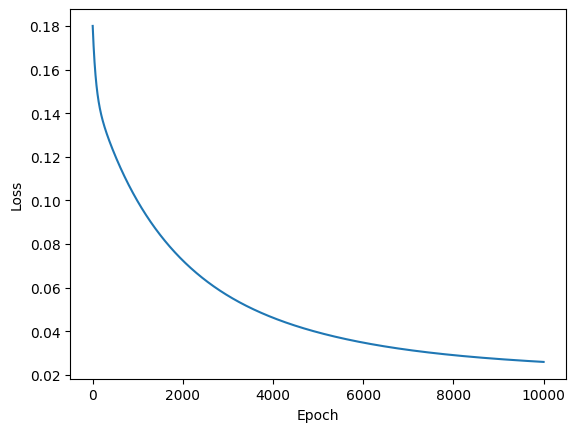

In [26]:
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

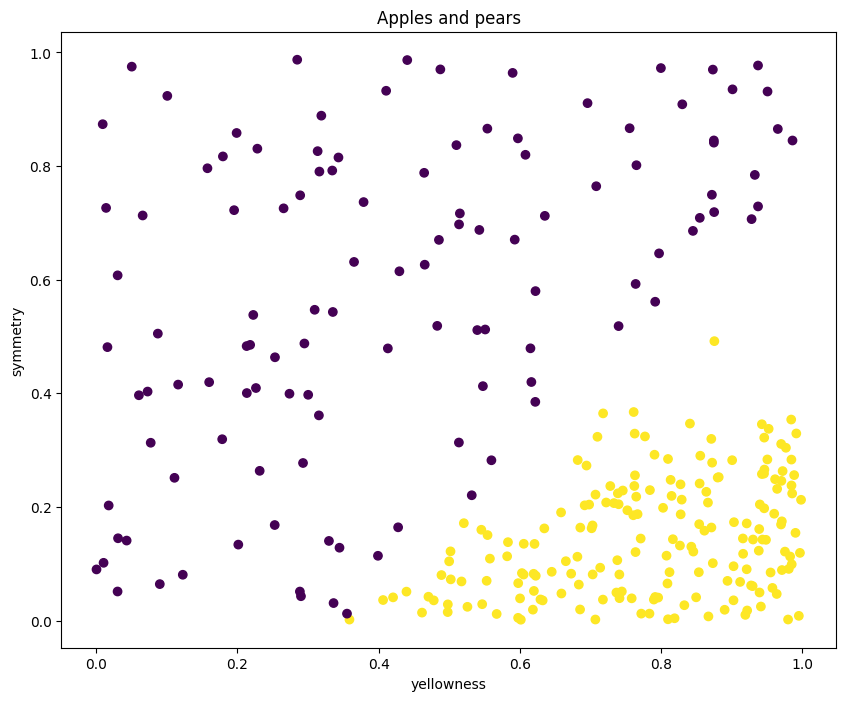

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       130
         1.0       0.92      0.99      0.95       170

    accuracy                           0.95       300
   macro avg       0.95      0.94      0.94       300
weighted avg       0.95      0.95      0.95       300



In [27]:
plt.figure(figsize=(10, 8))
y_pred = np.array(neuron.forward_pass(X_test) > 0.5).ravel()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.title('Apples and pears')
plt.xlabel('yellowness')
plt.ylabel('symmetry')
plt.show()
print(classification_report(y_test, y_pred))

**Плюсы E
LU:**

* дифференцируемая (с доопределнием в нуле)
* нет проблемы затухающих градиентов, как в сигмоиде
* нет проблемы "мёртвых нейронов", как в ReLU
* более устойчива к "шуму" (см. лекции Стэнфорда)

**Возможные минусы ELU:**

* не очень хорошо центрирована около 0 (может мешать скорости сходимсти)
* вычислительно дольше, чем ReLU и LeakyReLU